/tmp/ipython-input-14-1330154843.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sale Type'].fillna(df['Sale Type'].mode()[0], inplace=True)


Mean Squared Error: 1576043200.4933403
R² Score: 0.9974389482492296
Model saved to xgb_invoice_model_bundle.pkl


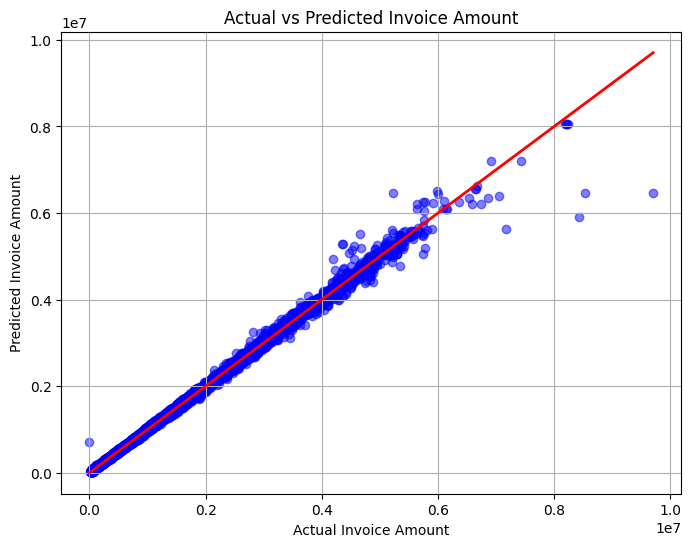

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load and preprocess
df = pd.read_csv("dataset ML.csv")
df.rename(columns={'Cutomer Type': 'Customer Type'}, inplace=True)
df['Billing date'] = pd.to_datetime(df['Billing date'], errors='coerce')
df['Billing_Day'] = df['Billing date'].dt.day
df['Billing_Month'] = df['Billing date'].dt.month
df['Billing_Year'] = df['Billing date'].dt.year
df.drop('Billing date', axis=1, inplace=True)

df['Sale Type'].fillna(df['Sale Type'].mode()[0], inplace=True)
df['Customer Code'] = df['Customer Code'].astype(int)

# Reorder columns
target_cols = ['Invoiced Quantity', 'Total Invoice Amount']
other_cols = [col for col in df.columns if col not in target_cols]
df = df[other_cols + target_cols]
cols = list(df.columns)
qty_idx = cols.index('Invoiced Quantity')
amt_idx = cols.index('Total Invoice Amount')
# Encode categoricals
categorical_cols = df.select_dtypes(include='object').columns
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# Train
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values  # Target: 'Total Invoice Amount'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
regressor = XGBRegressor()
regressor.fit(X_train, y_train)

# Evaluate
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R² Score:", r2)

# Save everything
model_bundle = {
    "model": regressor,
    "label_encoders": le_dict,
    "input_columns": df.columns[:-1].tolist()
}
joblib.dump(model_bundle, "xgb_invoice_model_bundle.pkl")
print("Model saved to xgb_invoice_model_bundle.pkl")

# Optional: Visualize
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Actual Invoice Amount')
plt.ylabel('Predicted Invoice Amount')
plt.title('Actual vs Predicted Invoice Amount')
plt.grid(True)
plt.show()


In [ ]:


# Save model bundle
model_bundle = {
    "model": regressor,
    "label_encoders": le_dict,
    "columns": list(X_df.columns)
}
joblib.dump(model_bundle, "xgb_invoice_model_bundle.pkl")
print("✅ Model saved as xgb_invoice_model_bundle.pkl")


✅ Model saved as xgb_invoice_model_bundle.pkl


In [ ]:
import gradio as gr
import pandas as pd
import joblib

# Load saved model and encoders
bundle = joblib.load("xgb_invoice_model_bundle.pkl")
model = bundle["model"]
label_encoders = bundle["label_encoders"]
model_columns = bundle["columns"]

# Load original dataset to get customer names
df = pd.read_csv("dataset ML.csv")
df.rename(columns={'Cutomer Type': 'Customer Type'}, inplace=True)
unique_customers = sorted(df["Customer Name"].dropna().unique().tolist())

# Prediction function
def predict_sales(customer_name, month):
    try:
        row = df[df["Customer Name"] == customer_name].iloc[-1:].copy()
        if row.empty:
            return "Error: Customer not found in data."

        row['Billing date'] = pd.to_datetime(row['Billing date'], errors='coerce')
        row['Billing_Day'] = row['Billing date'].dt.day
        row['Billing_Month'] = month
        row['Billing_Year'] = row['Billing date'].dt.year + 1
        row.drop('Billing date', axis=1, inplace=True)

        for col in label_encoders:
            row[col] = label_encoders[col].transform(row[col].astype(str))

        input_data = row[model_columns]
        prediction = model.predict(input_data)[0]
        return f"₹ {prediction:,.2f} (Predicted Total Invoice Amount)"

    except Exception as e:
        return f"Error: {str(e)}"

# Gradio UI
with gr.Blocks(theme=gr.themes.Monochrome()) as app:
    gr.Markdown("### 📊 Predict Next Quarter Sales")

    with gr.Row():
        customer = gr.Dropdown(choices=unique_customers, label="Customer Name")
        month = gr.Slider(1, 12, step=1, label="Month (1-12)", value=1)

    predict_btn = gr.Button("🔮 Predict")
    output = gr.Textbox(label="Prediction Result")

    predict_btn.click(fn=predict_sales, inputs=[customer, month], outputs=output)

app.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e66916fdcb7774a749.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
